# Connectionist Temporal Classification: A Study

This notebook is a part of a project to study Connectionist Temporal Classsification or CTC. CTC is a neural network output decoding and scoring algorithm that is used in sequence to sequence deep learning models when:  
- The length of the output sequence is less than the length of the input sequence and
- The order of the output w.r.t. the input is the same and 
- To align the shorter output w.r.t. the input, it makes sense to repeat the same output symbol in multiple steps.

CTC is primarily used in speech-recognition and OCR decoding.

This notebook explores usage of CTC algorithm for a use-case that satisfies the above criteria by creation of custom Keras model,accuracy metrics and loss function. You can visit the [project site]() for further details.

### 1. Read data and create custom model

In [1]:
import captcha_dataset as cds
import captcha_model
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K


IMG_DIR='/kaggle/input/captcha-version-2-images/samples'
image_width = 200
image_height = 50
batch_size = 64
downsample_factor = 4
max_label_len = 5

obj = cds.CaptchaData( IMG_DIR,image_height,image_width, batch_size,downsample_factor)
train, test = obj.split_train_test()
train = obj.make_batches(train)
num_classes  = obj.get_vocab_size()
model = captcha_model.CaptchaModel(num_classes, image_width, image_height )

### 2. Train the model
Custom loss and metrics are passed to the *model.fit* function. Since our custom model is extended from Keras.model class, we can use the standard Keras *fit* function to train the model.

In [2]:
m = captcha_model.CTCAccuracy(max_label_len)
model.compile(optimizer='adam', loss = captcha_model.loss_func, metrics= m )
hist = model.fit(train, epochs = 40)


Epoch 1/40
13/13 [==============================] - 28s 2s/step - loss: 68.5686 - ctc_accuracy: 0.0088
Epoch 2/40
13/13 [==============================] - 20s 2s/step - loss: 18.3547 - ctc_accuracy: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 20s 2s/step - loss: 17.0812 - ctc_accuracy: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 20s 2s/step - loss: 16.6551 - ctc_accuracy: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 20s 2s/step - loss: 16.4988 - ctc_accuracy: 0.0000e+00
Epoch 6/40
13/13 [==============================] - 20s 2s/step - loss: 16.4190 - ctc_accuracy: 0.0000e+00
Epoch 7/40
13/13 [==============================] - 20s 2s/step - loss: 16.3742 - ctc_accuracy: 0.0000e+00
Epoch 8/40
13/13 [==============================] - 20s 2s/step - loss: 16.3485 - ctc_accuracy: 0.0000e+00
Epoch 9/40
13/13 [==============================] - 20s 2s/step - loss: 16.3232 - ctc_accuracy: 0.0000e+00
Epoch 10/40
13/13 [======================

### 3. Evaluate the model
Once the training is complete, next step is to evaluate the model performance on test set. Since our custom model is extended from Keras.model class, we can use the standard Keras functions to evaluate the model.

In [3]:
X = obj.get_column( test, 0 )
X = obj.make_batches(X)
Y = obj.get_column( test, 1 )

test = obj.make_batches(test)
results =  model.evaluate( test )
print(results) 


4/4 [==============================] - 3s 362ms/step - loss: 0.1281 - ctc_accuracy: 0.9962
[0.12805616855621338, 0.9961538910865784]


### 4. Use the *model.predict* function to get the predictions generated by the model

In [4]:

def decode_predictions( pred, max_label_len ):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    encoded_labels =K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,0: max_label_len]
    decoded_labels = []
    for encoded_label in encoded_labels:
        i = 0
        label = []
        for code in encoded_label:
            if code.numpy() not in obj.label_int_to_char:
                label.append('?')
            else:
                label.append(obj.label_int_to_char[code.numpy()])
        decoded_labels.append(label)
    return decoded_labels, encoded_labels


pred = model.predict(X)
decoded_labels, encoded_labels = decode_predictions(pred,max_label_len )


### 5. Display the predictions along with the captcha images

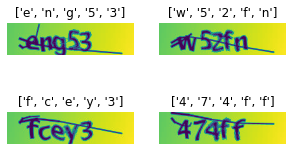

In [5]:
def display_samples( sample_images , labels):
    _,ax = plt.subplots(2,2, figsize=(5,3))
    for i in range(4):
        ax[i//2, i%2].imshow(np.transpose(sample_images[i],[1,0,2]) )
        ax[i//2, i%2].axis('off')
        ax[i//2, i%2].set_title(labels[i])
    plt.show()

it = X.as_numpy_iterator()
batch = it.next()
sample_images = [batch[i] for i in range(4)]
display_samples(sample_images,decoded_labels[0:4])       
     